In [178]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import random, copy

In [179]:
all_data = pd.read_csv("data/ankara_hk_data.csv")
all_data

,Unnamed: 0,S1_PM10,S1_PM25,S1_SO2,S1_NO2,S1_NOX,S1_NO,S2_PM10,S2_PM25,S2_SO2,...,S15_NOX,S15_NO,S15_O3,S17_PM10,S17_PM25,S17_SO2,S17_NO2,S17_NOX,S17_NO,S17_O3
0,0,25.78,59.82,12.86,159.93,334.79,174.86,191.10,42.08,6.73,...,237.45,129.30,1.24,168.93,72.57,8.70,232.58,592.46,359.88,3.10
1,1,25.78,59.82,12.86,159.93,334.79,174.86,171.00,44.11,6.94,...,237.45,129.30,1.24,168.93,72.57,8.70,232.58,592.46,359.88,3.10
2,2,8.58,59.39,12.96,125.96,245.34,119.38,143.50,43.53,5.50,...,172.76,89.14,3.97,175.13,85.43,11.11,262.78,673.75,410.96,2.72
3,3,23.25,64.53,12.15,129.92,263.59,133.67,125.50,39.14,5.50,...,212.22,113.78,4.13,181.77,95.19,11.17,263.56,681.37,417.82,3.55
4,4,25.34,57.17,10.96,150.52,324.17,173.65,112.80,35.81,4.94,...,163.40,82.48,3.86,179.82,89.47,9.90,219.58,559.38,339.79,2.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4716,8712,107.69,56.92,6.77,182.78,398.49,215.71,82.50,32.16,7.01,...,337.08,195.48,3.42,206.80,3.79,6.18,181.39,390.98,209.58,16.33
4717,8713,102.60,60.38,6.02,136.34,272.04,135.70,71.07,34.54,7.34,...,324.77,187.08,3.20,144.44,2.66,6.38,215.20,504.85,289.65,16.55
4718,8714,93.04,53.38,6.79,161.60,346.15,184.55,75.17,30.45,7.63,...,240.77,133.61,3.16,165.70,1.86,5.92,212.83,505.12,292.29,16.26
4719,8715,108.01,66.41,7.75,110.36,208.99,98.63,81.67,24.94,7.77,...,265.22,150.26,3.06,134.59,1.30,6.02,194.26,455.72,261.46,16.34


In [180]:
def sub_dataframe(df: pd.DataFrame,
                  pollutant: str = None,
                  station: str = None,
                  data_completeness: float = None,
                  year: int = None):
    if pollutant is None and station is None and data_completeness is None and year is None:
        print("No selection criteria!")
        return df

    neo_df = copy.deepcopy(df)

    # Filter Pollutants
    if pollutant is not None:
        for column_name in neo_df.columns:
            if pollutant not in column_name and column_name != 'DATE':
                neo_df = neo_df.drop([column_name], axis=1)

    # Filter Stations
    if station is not None:
        for column_name in neo_df.columns:
            if str(station + "_") not in column_name and column_name != 'DATE':
                neo_df = neo_df.drop([column_name], axis=1)

    # Filter Data Completeness
    if data_completeness is not None:
        for column_name in neo_df.columns:
            if completeness_feature(neo_df[column_name]) < data_completeness and column_name != 'DATE':
                neo_df = neo_df.drop([column_name], axis=1)

    # Filter Year
    if year is not None:
        neo_df = neo_df[neo_df['DATE'].str.contains(str(year))]

    return neo_df

pols = ["NO2", "PM10", "O3", "PM25"]
pol_levels = {"NO2": [50, 100, 200, 400],
              "PM10": [25, 50, 90, 180],
              "O3": [60, 120, 180, 240],
              "PM25": [15, 30, 55, 110]}

def polcon2AQI(pol_name: str, val:float):
    global pols
    registered_pollutant = False
    pol_id = None
    for pol in pols:
        if pol in pol_name:
            registered_pollutant = True
            pol_id = pol
    if not registered_pollutant:
        return 0
    if val < pol_levels[pol_id][0]:
        return 1
    elif val < pol_levels[pol_id][1]:
        return 2
    elif val < pol_levels[pol_id][2]:
        return 3
    elif val < pol_levels[pol_id][3]:
        return 4
    return 5


def generate_class_label(row: pd.Series):
    vals = []
    for key in row.keys():
        vals.append(polcon2AQI(pol_name=key,
                               val=row[key]))
    return max(vals)


def generate_class_labels(df: pd.DataFrame):
    AQIs = []
    for index, row in df.iterrows():
        AQIs.append(generate_class_label(row=dict(row)))
    AQIs.append(0)
    df.loc[:, "OUT"] = AQIs[1:]
    return df



In [181]:
s1_data = sub_dataframe(df=all_data, station='S1')
s2_data = sub_dataframe(df=all_data, station='S2')
s9_data = sub_dataframe(df=all_data, station='S9')
s14_data = sub_dataframe(df=all_data, station='S14')
s15_data = sub_dataframe(df=all_data, station='S15')
s17_data = sub_dataframe(df=all_data, station='S17')

In [182]:
s1_data

,S1_PM10,S1_PM25,S1_SO2,S1_NO2,S1_NOX,S1_NO
0,25.78,59.82,12.86,159.93,334.79,174.86
1,25.78,59.82,12.86,159.93,334.79,174.86
2,8.58,59.39,12.96,125.96,245.34,119.38
3,23.25,64.53,12.15,129.92,263.59,133.67
4,25.34,57.17,10.96,150.52,324.17,173.65
...,...,...,...,...,...,...
4716,107.69,56.92,6.77,182.78,398.49,215.71
4717,102.60,60.38,6.02,136.34,272.04,135.70
4718,93.04,53.38,6.79,161.60,346.15,184.55
4719,108.01,66.41,7.75,110.36,208.99,98.63


In [183]:
exp_s1_data = generate_class_labels(s1_data)
exp_s2_data = generate_class_labels(s2_data)
exp_s9_data = generate_class_labels(s9_data)
exp_s14_data = generate_class_labels(s14_data)
exp_s15_data = generate_class_labels(s15_data)
exp_s17_data = generate_class_labels(s17_data)

In [184]:
exp_s2_data

,S2_PM10,S2_PM25,S2_SO2,S2_CO,S2_03,OUT
0,191.10,42.08,6.73,2132.53,4.84,4
1,171.00,44.11,6.94,1972.46,4.57,4
2,143.50,43.53,5.50,1696.22,3.94,4
3,125.50,39.14,5.50,1304.05,3.36,4
4,112.80,35.81,4.94,1132.15,3.18,4
...,...,...,...,...,...,...
4716,82.50,32.16,7.01,2558.69,15.40,3
4717,71.07,34.54,7.34,2849.30,15.60,3
4718,75.17,30.45,7.63,2809.52,15.24,3
4719,81.67,24.94,7.77,2967.26,15.57,3


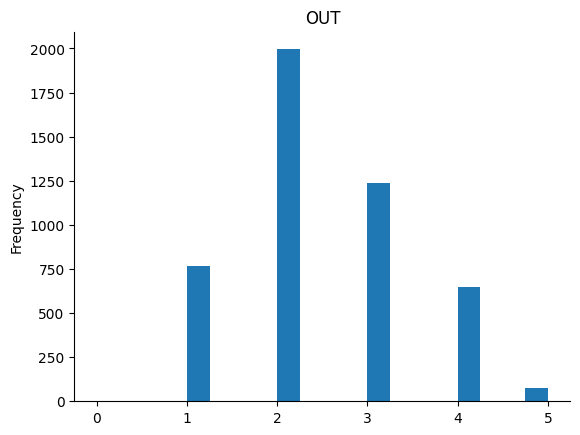

In [185]:
from matplotlib import pyplot as plt
exp_s17_data['OUT'].plot(kind='hist', bins=20, title='OUT')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [186]:
filtered_data = exp_s17_data[exp_s17_data["OUT"]!=0]
np.unique(filtered_data["OUT"].values,return_counts=True)

(array([1, 2, 3, 4, 5]), array([ 765, 1995, 1237,  645,   78]))

In [187]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(filtered_data[filtered_data.columns[:-1]].values, filtered_data[filtered_data.columns[-1]].values,
                                                    stratify=filtered_data[filtered_data.columns[-1]].values, test_size=0.3, random_state=42)

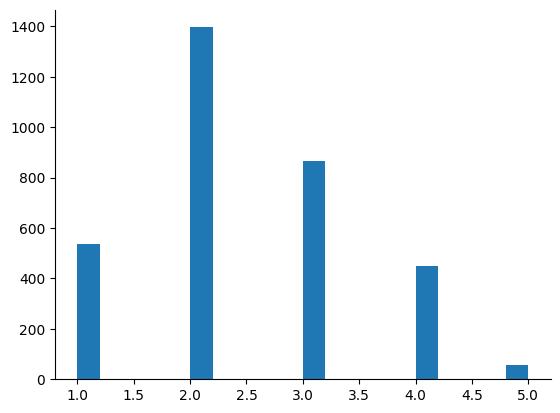

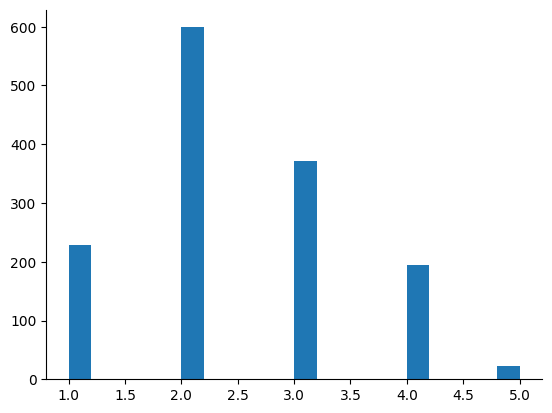

In [188]:
plt.hist(y_train, bins=20)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.pause(0.05)
plt.hist(y_test, bins=20)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [189]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)

In [190]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
svm = SVC(gamma='auto')

# train the model on train set
svm.fit(X_train_transformed, y_train)

predictions = svm.predict(X_test_transformed)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.75      0.70      0.73       229
           2       0.80      0.84      0.82       599
           3       0.75      0.80      0.77       371
           4       0.87      0.73      0.79       194
           5       0.79      0.65      0.71        23

    accuracy                           0.79      1416
   macro avg       0.79      0.74      0.76      1416
weighted avg       0.79      0.79      0.79      1416



In [199]:
lr = LogisticRegression()
# train the model on train set
lr.fit(X_train_transformed, y_train)

predictions = lr.predict(X_test_transformed)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.72      0.59      0.65       229
           2       0.75      0.85      0.80       599
           3       0.75      0.75      0.75       371
           4       0.83      0.74      0.78       194
           5       0.77      0.43      0.56        23

    accuracy                           0.76      1416
   macro avg       0.77      0.67      0.71      1416
weighted avg       0.76      0.76      0.75      1416



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [200]:
from imblearn.over_sampling import SMOTE
sample_size={1:800,4:800,5:800}
sm = SMOTE(sampling_strategy=sample_size,random_state = 42)
X_over_sampled, y_over_sampled = sm.fit_resample(X_train_transformed, y_train)

In [201]:
from imblearn.over_sampling import RandomOverSampler
sample_size={1:800,4:800,5:800}
ros = RandomOverSampler(sampling_strategy=sample_size,random_state=42)
X_random_over_sampled, y_random_over_sampled  = ros.fit_resample(X_train_transformed, y_train)

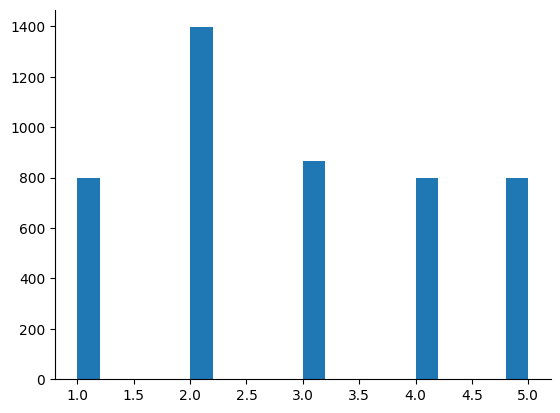

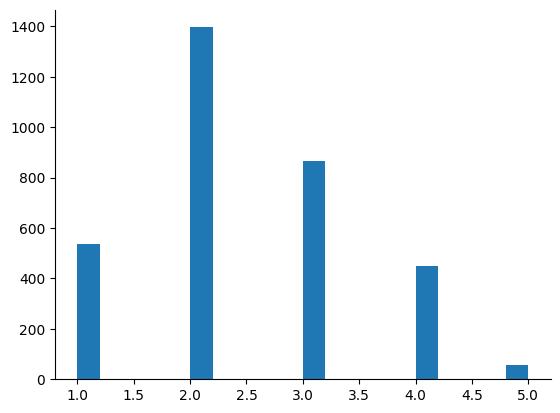

In [202]:
plt.hist(y_over_sampled, bins=20)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.pause(0.05)
plt.hist(y_train, bins=20)
plt.gca().spines[['top', 'right',]].set_visible(False)


In [203]:
svm = SVC(gamma='auto')

# train the model on train set
svm.fit(X_over_sampled, y_over_sampled)

predictions = svm.predict(X_test_transformed)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.69      0.78      0.74       229
           2       0.82      0.79      0.80       599
           3       0.76      0.76      0.76       371
           4       0.81      0.74      0.77       194
           5       0.47      0.65      0.55        23

    accuracy                           0.77      1416
   macro avg       0.71      0.74      0.72      1416
weighted avg       0.78      0.77      0.77      1416



In [204]:
svm = SVC(gamma='auto')

# train the model on train set
svm.fit(X_random_over_sampled, y_random_over_sampled)

predictions = svm.predict(X_test_transformed)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.70      0.78      0.74       229
           2       0.82      0.80      0.81       599
           3       0.77      0.75      0.76       371
           4       0.81      0.76      0.78       194
           5       0.52      0.74      0.61        23

    accuracy                           0.77      1416
   macro avg       0.72      0.76      0.74      1416
weighted avg       0.78      0.77      0.78      1416



In [205]:
lr = LogisticRegression()
# train the model on train set
lr.fit(X_over_sampled, y_over_sampled)

predictions = lr.predict(X_test_transformed)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.66      0.72      0.69       229
           2       0.77      0.79      0.78       599
           3       0.75      0.68      0.71       371
           4       0.76      0.70      0.73       194
           5       0.45      0.83      0.58        23

    accuracy                           0.74      1416
   macro avg       0.68      0.74      0.70      1416
weighted avg       0.74      0.74      0.74      1416



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [206]:
lr = LogisticRegression()
# train the model on train set
lr.fit(X_random_over_sampled, y_random_over_sampled)

predictions = lr.predict(X_test_transformed)

# print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       0.66      0.72      0.68       229
           2       0.77      0.79      0.78       599
           3       0.76      0.67      0.72       371
           4       0.77      0.69      0.73       194
           5       0.43      0.87      0.57        23

    accuracy                           0.74      1416
   macro avg       0.68      0.75      0.70      1416
weighted avg       0.74      0.74      0.74      1416



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
